# Introductoin


This tutorial focuses on how representation/knowledge is learnt in deep neural networks. 

The network's weights are initialised at the start from random distributions (e.g., uniform or Gaussian). Throughout the *learning process*, they get tuned to a set of features useful for the task they are being optimised to perform.

Broadly speaking, the learning process consists of:
1. Comparing the network's output to the expected value (ground truth).
2. Using the backpropagation algorithm to compute the gradient of the loss function with respect to all networks' parameters.
3. Updating the weights by stepping in the direction of the gradient for a given parameter. 

These three steps correspond are implemented in the following lines of code, typical to any deep learning project (e.g., [building a DNN project notebook](https://github.com/ArashAkbarinia/mbb/blob/main/notebooks/build_DNN_project.ipynb) that we saw in the previous class.)
```
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.zero_grad()
```

By the end of this class, you will have a better understanding of:
* What is a loss function?
* The intuition behind optimisation algorithms.
* How do hyperparameters influence the learning process?
 
To answer these questions, we will look at a few simple binary classification toy examples.

# 0. Preparation
## Packages

Let's start with all the necessary packages to implement this tutorial.

 * [numpy](https://numpy.org/) is the main package for scientific computing with Python. It's often imported with the `np` shortcut.
 * [matplotlib](https://matplotlib.org/) is a library to plot graphs in Python.
 * [torch](https://pytorch.org/docs/stable/index.html) is a deep learning framework that allows us to define networks, handle datasets, optimise a loss function, etc.

In [3]:
# importing the necessary packages/libraries
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
import torchvision

## Device
Choosing CPU or GPU based on the availability of the hardware. In this toy example, even the CPU would be sufficient. although it will be fairly slow. However, in real-world applications, a GPU is always necessary.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Dataset

We define four datasets of 2D points (inspired by [Andrej Karpathy](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)):
1. *Linear*: the data points are linearly separable.
2. *Circular*: the data points are separable by the radii of their circles.
3. *Spiral*: the data points follow the equation of [Archimedean spiral](https://en.wikipedia.org/wiki/Archimedean_spiral) in different directions.
4. *Random*: the data points are randomly generated in a 2D space.

The task is binary classification: the network has to learn to which category each point belongs.

## Dataset utility functions
We define a set of utility functions to generate our four datasets. All data generator functions return two variables:
* `points` is a list of `n` points with their $(x, y)$ coordinates. The shape of this array is $n \times 2$.
* `labels` corresponding to each point specifying its category (i.e., 0 or 1 ). The shape of this array is $n$.

The `points` for each dataset are already centred at 0, therefore, we don't need to call the normalize function.

In [5]:
def random_2d(num_points):
    """"Generates a datset of 2D points in the range of [-1, 1] with a random label assigned to them."""
    points = np.random.uniform(-1, 1, (num_points, 2))
    labels = np.random.randint(0, 2, num_points)
    return points, labels


def circular_2d(num_points):
    """Generated a dataset of circular 2D points."""
    half_num_pts = num_points // 2
    # Those with label 0 have a radius in the range of [0.1, 0.3]
    # Those with label 1 have a radius in the range of [0.5, 0.7]
    polar_pts = np.array([
        *np.array([np.random.uniform(0.1, 0.3, half_num_pts), np.random.uniform(0, np.pi * 2, half_num_pts)]).T,
        *np.array([np.random.uniform(0.5, 0.7, half_num_pts), np.random.uniform(0, np.pi * 2, half_num_pts)]).T
    ])
    # converting the polar points to cartesian coordinates
    points = np.array([polar_pts[:, 0] * np.sin(polar_pts[:, 1]), polar_pts[:, 0] * np.cos(polar_pts[:, 1])]).T
    labels = np.array([*[0] * half_num_pts, *[1] * half_num_pts])
    return points, labels

def spiral_2d(num_points):
    """Generated a dataset of spiral 2D points."""
    half_num_pts = num_points // 2
    points = []
    labels = []
    # Points with label 0 swirl clockwise.
    for i in range(half_num_pts):
        r = i / half_num_pts * 5
        t = 1.75 * i / half_num_pts * 2 * np.pi + 0
        points.append([r * np.sin(t) + np.random.uniform(-0.1, 0.1), r * np.cos(t) + np.random.uniform(-0.1, 0.1)])
        labels.append(0)
    # Points with label 1 swirl unclockwise.
    for i in range(half_num_pts):
        r = i / half_num_pts * 5
        t = 1.75 * i / half_num_pts * 2 * np.pi + np.pi
        points.append([r * np.sin(t) + np.random.uniform(-0.1, 0.1), r * np.cos(t) + np.random.uniform(-0.1, 0.1)])
        labels.append(1)
    return np.array(points), np.array(labels)

def linear_2d(num_points):
    """Generates a dataset of 2D poins that are linearly seperable."""
    points = np.random.uniform(-1, 1, (num_points, 2))
    # The boundary line.
    line = np.array([[-0.9, -0.7], [1.0, 0.6]])
    # Points with label 0 are above the line and points with label 1 are below the line.
    is_above = lambda p,l: np.cross(p - l[0], l[1] - l[0]) < 0
    labels = []
    for p in points:
        labels.append(0 if is_above(p, line) else 1)
    return points, np.array(labels)

## Visualising the dataset
We create the `plot_db` function that plots all the points and colour codes them according to their label. Points with label <span style="color:red">**0**</span> are in red and points with label <span style="color:blue">**1**</span> are in blue.

In [6]:
def plot_db(data, title, ax=None):
    points, labels = data
    
    xs = points[:, 0]
    ys = points[:, 1]
    cdict = {0: 'red', 1: 'blue'}

    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.add_subplot(1, 1, 1)
    for l in np.unique(labels):
        ix = np.where(labels == l)
        ax.scatter(xs[ix], ys[ix], c=cdict[l], label=l, s=10)
    ax.legend()
    ax.set_title(title)
    ax.axis('equal')

We are putting all four datasets into a dictionary. This allows us to access them easily by looping through all the dictionary items, for instance for visualisation.

In [7]:
number_points = 1000
dbs = {
    'random_data': random_2d(number_points),
    'circular_data': circular_2d(number_points),
    'spiral_data': spiral_2d(number_points),
    'linear_data': linear_2d(number_points)
}

Intuitively from the datasets plots, we can see that except for the random dataset, the rest are easily separable (at least to our eyes). The question we study in this tutorial is whether this holds for deep networks as well.

We can also observe that the $(x, y)$ coordinates of all four datasets are in the range of $(-std, +std)$. Therefore we do not need to apply the normalisation function (`torchvision.transforms.Normalize(mean, std)`).

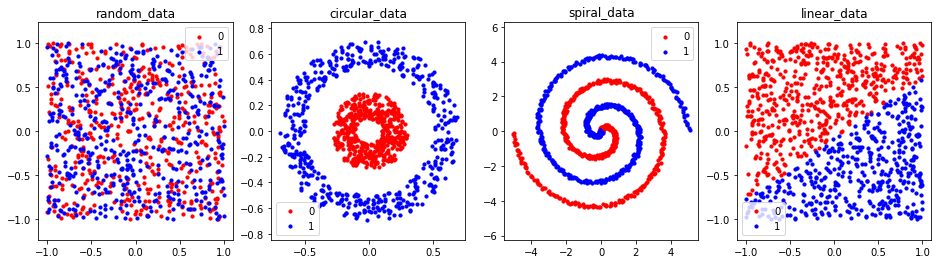

In [9]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

## Train/test splits

For each dataset, we split it into two sets:
 * **train** containing 90% of the points.
 * **test** containing 10% of the points.

In [10]:
train_dbs = dict()
test_dbs = dict()
num_tests = number_points // 10
for db_ind, (db_key, db_val) in enumerate(dbs.items()):
    points, labels = db_val
    # creating a sorted array from 0 to 999 (number_points).
    shuffle_inds = np.arange(number_points)
    # we shuffle around the indices to obtain random train/test sets.
    random.shuffle(shuffle_inds)
    train_dbs[db_key] = points[shuffle_inds[:-num_tests]], labels[shuffle_inds[:-num_tests]]
    test_dbs[db_key] = points[shuffle_inds[-num_tests:]], labels[shuffle_inds[-num_tests:]]

Plotting the **train** set.

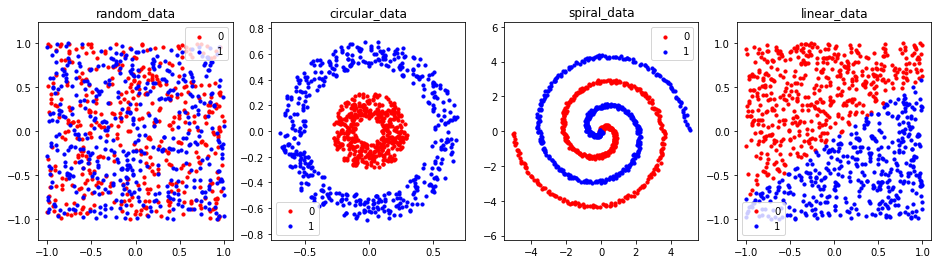

In [12]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(train_dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

Plotting the **test** set. We can observe that points are much more sparse in comparison to the training set.

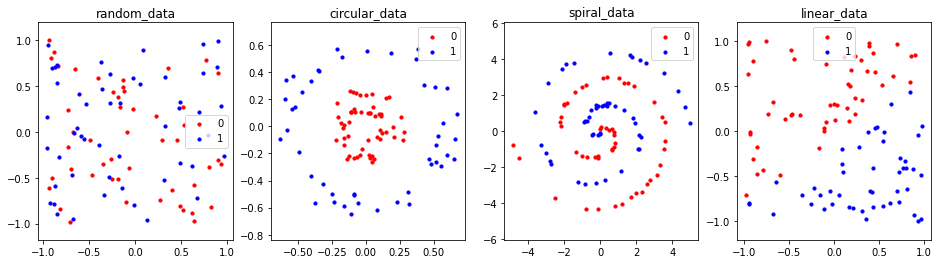

In [13]:
fig = plt.figure(figsize=(16, 4))
for db_ind, (db_key, db_val) in enumerate(test_dbs.items()):
    ax = fig.add_subplot(1, len(dbs), db_ind+1)
    plot_db(db_val, db_key, ax)

## Evaluation

We define accuracy as the metric to report how good or bad an algorithm does in classifying the points into two categories. We define a function to compute the `accuracy` of the output with respect to ground truth.

In [27]:
def accuracy(y_pred, y_true):
    """Calculate accuracy (a classification metric)"""
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

# 2. Model

We have successfully created our datasets. Next, we design a simple network.
 * `Simple2DNetwork` is a subclass of the `nn.Module`. It must implement the `forward` function.
 * It only contains 3 layers, two linear and one non-linear activation function (ReLU).

In [47]:
class Simple2DNetwork(nn.Module):
    def __init__(self, weight_init='uniform'):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5) # in_features must be 2 because our data is (x, y).
        self.linear2 = nn.Linear(in_features=5, out_features=1) # out_features equals 1 because of binary classification.
        self.relu = nn.ReLU()
        
        # initialising the weights and their biases
        if weight_init == 'uniform':
            nn.init.uniform_(self.linear1.weight)
            nn.init.uniform_(self.linear2.weight)
        elif weight_init == 'xavier':
            nn.init.xavier_normal_(self.linear1.weight)
            nn.init.xavier_normal_(self.linear2.weight)
    
    # Define a forward method containing the forward pass computation
    # It's common to use the same variable name throughout the forward stream, in this case "x".
    # This is only to simplify coding, input/outpts to all layers would have the same variable name.
    def forward(self, x):
        # The input data is processed by the first linear layer.
        x = self.linear1(x)
        # The output of the first layer is rectified with ReLU.
        x = self.relu(x)
        # The second linear layer produces the output value.
        x = self.linear2(x)
        return x

# Creating an instance of the model and send it to target device
model = Simple2DNetwork().to(device)
print(Simple2DNetwork())

Simple2DNetwork(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


In theroy we could have created our `Simple2DNetwork` with fewer lines of code using `nn.Sequential`:
```
    model = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.ReLU(),
        nn.Linear(in_features=5, out_features=1)
    )
```
This implementation is useful when prototyping very simple networks. As soon as the network becomes a bit more complicated (e.g., the weight initialisation if statement), one has to create a `class` as we did in the previous cell. 

# 3. Loss

How do we know if the output of our network is good or bad? We need a metric to quantify how close the output is to ground truth. A *loss* function calculates the error of the output. The smaller the better. 

**Loss function** measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

There are several loss functions implemented in deep learning frameworks (e.g. [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions). Going through all of them is beyond the purpose of this tutorial. We only look at four of those in this tutorial:
* `nn.L1Loss` is the mean absolute error (MSA).
* `nn.MSELoss` is the mean square error (MSE) also known as L2.
* `nn.SmoothL1Loss` and `nn.HuberLoss` combine L1 (MSA) and L2 (MSE) together.
* `nn.BCELoss` (Binary Cross Entropy) is designed for binary classification problems (contrary to the other losses explained above that are typically used in a regression). In practice, we often use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) that combines a *Sigmoid* layer and the *BCELoss* in one single class. 

To have a better intuition about each of these loss functions, we plot the error as a function of prediction value for a scenario where the ground truth equals 0.

Qualitatively all the "regression" losses (i.e., *L1, MSE, SmoothL1 and Huber*) are similar but the degree of smoothness varies from the minimum to maximum error. It can also be noted that the maximum error varies in those losses.

In the "classification" loss (*Binary Cross Entropy*) error exponentially increases as prediction deviates from the ground truth.

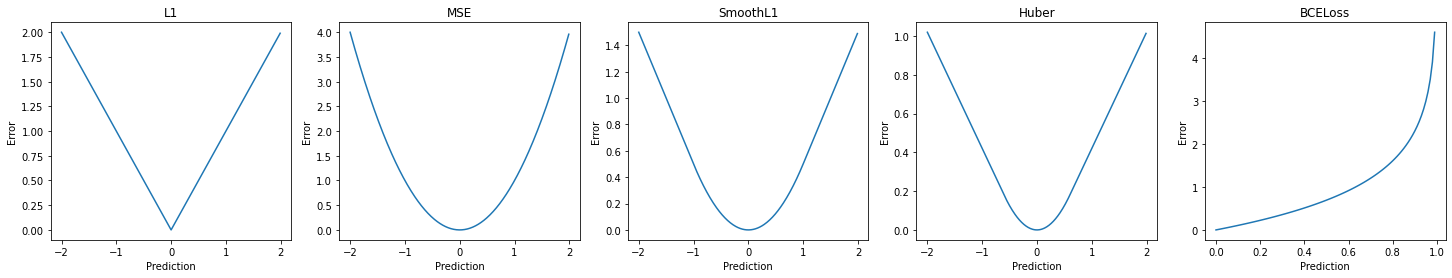

In [24]:
losses = {
    'L1': nn.L1Loss(reduction='none'),
    'MSE': nn.MSELoss(reduction='none'),
    'SmoothL1': nn.SmoothL1Loss(reduction='none'),
    'Huber': nn.HuberLoss(reduction='none', delta=0.6),
    'BCELoss': nn.BCELoss(reduction='none'),
}

fig = plt.figure(figsize=(5 * len(losses), 4))
for loss_ind, (loss_key, loss_val) in enumerate(losses.items()):
    if loss_key in ['BCELoss']:
        # in Binary Cross Entropy the output is between o to 1 (corresponding to two categories).
        x_vals = torch.tensor(np.arange(0, 1, 0.01))
        target = torch.zeros(x_vals.shape).double()
    else:
        x_vals = torch.tensor(np.arange(-2, 2, 0.01))
        target = torch.zeros(x_vals.shape)
    ax = fig.add_subplot(1, len(losses), loss_ind+1)
    y_vals = loss_val(x_vals, target)
    ax.plot(x_vals, y_vals)
    ax.set_title(loss_key)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Error')

## Custom loss
On many occasions, one needs to implement its own loss function. For instance, imagine circular data (e.g., hue or angle). In these scenarios, the error between $0$ and $2 \pi$ degree should be 0. If we use the above-mentioned loss, the error would be the maximum error.

**Question** for one of the regression loss functions (e.g., MSE) implement its circular version.

# 4. Optimizer

![](https://1349742019-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LGHUhl6VYqrZm4Re77O%2F-LGHay3_3SD1W_7T7wut%2F-LGHb1O2LFqXqdQwZ0Hi%2FScreen%20Shot%202018-06-29%20at%204.19.11%20PM.png?alt=media&token=379fb74a-9549-4156-847f-0b7006357c16)

Think about walking around a large valley, and finding the bottom of this valley. Or teleporting around the Valley, each batch is the area we can see. And if we see large enough and good enough, we could just teleport to the best spot we could see. It is very hard to see an optimal way. So we use an iterative method, to improve it every time.

1. **Random search**: having a set of W, and just TRY. And using it would be horrible and need a lifetime to finish.
2. Using the local geometry. Maybe we can’t just see the bottom of the valley, but **use your foot to feel the slope of the ground and take which way will take you a bit down** to the valley.
   * So **what is the slope?** The slope is the derivative of the loss function.
   * **Gradient**: it will give you the direction of the greatest increase to the target function; and if you look at the negative gradient, you will find the direction of the greatest decrease to the target function. It’s a vector sharing the same shape as the parameters and each slot of representing how much loss will be changed if the parameter moves an infinitesimal amount in the direction.
   * **Numerical & Analytic gradient**: the Numerical is approximate, slow and easy to write; but the Analytic is exact, fast and error-prone.
   * **Gradient Check**: Always use an Analytic gradient for training, but check implementation with a numerical gradient. This is called gradient check.

There are several different optimizers. Read more about them [here](https://sisyphus.gitbook.io/project/deep-learning-basics/basics/optimization).

We create an SGD (Stochastic gradient Decent) optimizer which defines the process of adjusting model parameters to reduce model error in each training step.

`torch.optim.SGD` requires at least two arguments:
* `params` which parameters to optimise, in this all the parameters of our model.
* `lr` (learning rate) which defines how fast the parameters are to be updated. Smaller values yield slow learning speed, while large values may result in unpredictable behaviour during training.

In [25]:
learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# 5. Initialisation

In the valley picture, depending on where you're standing you might see different paths. Your **initial position** can influence your journey and where you end up. Correspondingly, in neural networks, the initial weights of all layers can have an impact on the learning outcome. While this is outside of the scope of this tutorial. We just look at a few **weight initialization** techniques to familiarise ourselves with this possibility.

## Untrained features
Let's make a prediction using our model without any training. How good *untrained features* can do in this binary classification problem?

In this tutorial, we look at the linear dataset.
**Question**: is there a performance difference on other datasets?

In [43]:
which_db = 'linear_data'
input_data = torch.tensor(test_dbs[which_db][0]).float().to(device)
target = torch.tensor(test_dbs[which_db][1]).to(device)

model.eval()
untrained_preds = model(input_data)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(target)}, Shape: {target.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{target[:10]}")

Length of predictions: 100, Shape: torch.Size([100, 1])
Length of test samples: 100, Shape: torch.Size([100])

First 10 predictions:
tensor([[2.9966],
        [0.9725],
        [5.2745],
        [1.7471],
        [3.3775],
        [4.9822],
        [1.4055],
        [2.9712],
        [3.3710],
        [3.7974]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')


The model output is a continuous value contrary to the ground truth that is discrete (0 or 1). This is because the model output is a probability of belonging to category 0 or 1. The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specifically:
* If `y_pred_probs` >= 0.5, `y=1` (category 1)
* If `y_pred_probs` < 0.5, `y=0` (category 0)

So, to compute the accuracy, we should convert the probabilities to a label by the above equation.

Furthermore, we can see that the shape of the prediction is `[100, 1]` therefore we have to call the `squeeze()` function to get rid of this unnecessary extra dimension and convert the prediction to a vector.

We obtain an accuracy close to the chance level ($50\%$) demonstrating that the untrained features cannot solve the task and they need to be tuned.

In [44]:
untrained_preds_labels = untrained_preds >= 0.5
untrained_acc = accuracy(untrained_preds_labels.squeeze(), target)
print('The accuracy with untrained features: %.1f%%.' % untrained_acc)

The accuracy with untrained features: 48.0%.


## Xavier Normal Distribution
Let's fill in our model with [xavier_normal](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_normal_) and check whether the initial performance would be different. The initial performance is still at the chance level.

**Question**: investigate whether the initialisation technique has an impact on the training.

In [49]:
model = Simple2DNetwork('xavier').to(device)
model.eval()
untrained_preds = model(input_data)
untrained_preds_labels = untrained_preds >= 0.5
untrained_acc = accuracy(untrained_preds_labels.squeeze(), target)
print('The accuracy with Xavier untrained features: %.1f%%.' % untrained_acc)

The accuracy with Xavier untrained features: 50.0%.


# 5. Back propogation

```
for (x, y) in zip(X_train_tensor_gpu, y_train_tensor_gpu): # loop through observations and labels
    net.zero_grad() # remove calculated derivatives
    y_hat = net(X_tensor)             # 1. Forward prop: With current weights make a prediction
    loss = criterion(y_hat, y_tensor) # 2. See how off the prediction is according to the cost function
    loss.backward()                   # 3. Back prop: Calculate how each layer's change in output affects J
    opt.step()                        # 4. Update params based on eta and calculated derivatives 
```

# 7. Train/test

In [55]:
def epoch_loop(model, db, criterion, optimiser):
    # usually the code for train/test has a large overlap.
    is_train = False if optimiser is None else True

    # model should be in train/eval model accordingly
    model.train() if is_train else model.eval()
    with torch.set_grad_enabled(is_train):
        # moving the image and GT to device
        input_data = torch.tensor(db[0]).float().to(device)
        target = torch.tensor(db[1]).float().to(device)
        prediction = model(input_data)
        # making it one hot vector
        prediction = prediction.squeeze()
        
        pred_labels = prediction >= 0.5

        # computing the loss function
        loss = criterion(prediction, target)
        # computing the accuracy
        acc = accuracy(pred_labels, target)

        if is_train:
            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return acc, loss.item(), pred_labels.detach().cpu().numpy()

In [88]:
model = Simple2DNetwork().to(device)

criterion = nn.L1Loss()

learning_rate = 0.1
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# doing epoch
which_db = 'circular_data'

epochs = 1000
print_freq = epochs // 10
initial_epoch = 0
train_logs = {'acc': [], 'loss': [], 'pred': []}
val_logs = {'acc': [], 'loss': [], 'pred': []}
for epoch in range(initial_epoch, epochs):
    train_log = epoch_loop(model, train_dbs[which_db], criterion, optimizer)
    
    val_log = epoch_loop(model, test_dbs[which_db], criterion, None)
    
    if np.mod(epoch, print_freq) == 0:
        print('[%.2d] Train     loss=%.4f     acc=%0.2f    [%.2d] Test     loss=%.4f     acc=%0.2f' % 
              (
                  epoch, np.mean(train_log[1]), np.mean(train_log[0]),
                  epoch, np.mean(val_log[1]), np.mean(val_log[0])
              ))
    train_logs['acc'].append(np.mean(train_log[0]))
    train_logs['loss'].append(np.mean(train_log[1]))
    train_logs['pred'].append(train_log[2])
    val_logs['acc'].append(np.mean(val_log[0]))
    val_logs['loss'].append(np.mean(val_log[1]))
    val_logs['pred'].append(val_log[2])

[00] Train     loss=0.4800     acc=55.67    [00] Test     loss=0.4363     acc=61.00
[100] Train     loss=0.3763     acc=64.89    [100] Test     loss=0.3847     acc=64.00
[200] Train     loss=0.3341     acc=65.33    [200] Test     loss=0.3525     acc=64.00
[300] Train     loss=0.2578     acc=85.89    [300] Test     loss=0.2895     acc=83.00
[400] Train     loss=0.1999     acc=89.00    [400] Test     loss=0.2098     acc=88.00
[500] Train     loss=0.1525     acc=99.33    [500] Test     loss=0.1590     acc=100.00
[600] Train     loss=0.1186     acc=100.00    [600] Test     loss=0.1276     acc=100.00
[700] Train     loss=0.1176     acc=100.00    [700] Test     loss=0.1245     acc=100.00
[800] Train     loss=0.1179     acc=100.00    [800] Test     loss=0.1258     acc=100.00
[900] Train     loss=0.1175     acc=100.00    [900] Test     loss=0.1252     acc=100.00


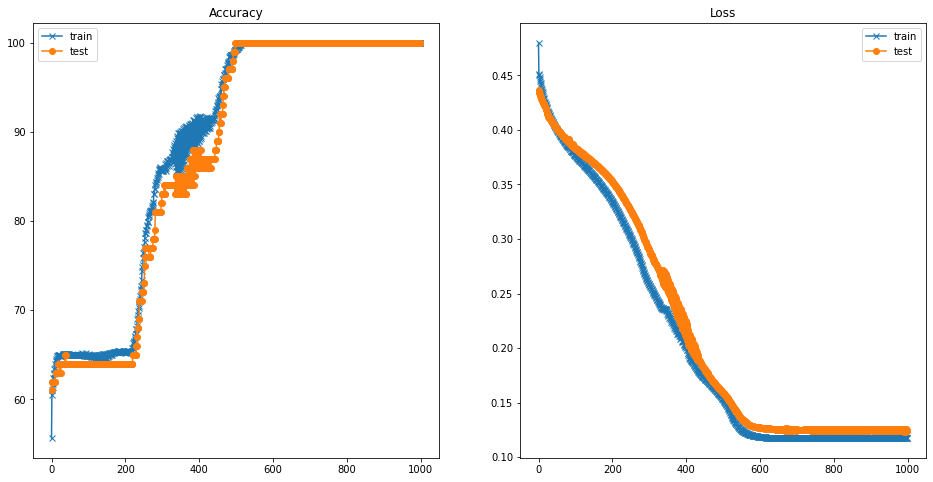

In [89]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_logs['acc'], '-x', label='train')
ax.plot(val_logs['acc'], '-o', label='test')
ax.set_title('Accuracy')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_logs['loss'], '-x', label='train')
ax.plot(val_logs['loss'], '-o', label='test')
ax.set_title('Loss')
ax.legend()